# Setup

To run this notebook on Colab, a few setup steps are required. Follow along step by step:

1. **Clone the `dlfb` library**  
   First, clone the repository that contains the `dlfb` library.

In [1]:
%cd /content
!rm -rf ./dlfb-clone/
!git clone "https://github.com/deep-learning-for-biology/dlfb.git" dlfb-clone --branch main
%cd dlfb-clone

/content
Cloning into 'dlfb-clone'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 121 (delta 19), reused 111 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (121/121), 62.31 KiB | 12.46 MiB/s, done.
Resolving deltas: 100% (19/19), done.
/content/dlfb-clone


2. **Install dependencies**  
   Once the library is cloned, install the required dependencies.

In [2]:
%%bash
curl -LsSf https://astral.sh/uv/install.sh | sh && \
export PATH="/root/.local/bin:${PATH}" && \
uv pip compile ./requirements/{base,dlfb,dna,gpu}.txt \
  --color never \
  --constraint ./requirements/constraints.txt | \
uv pip install -r - --system

no checksums to verify
installing to /usr/local/bin
  uv
  uvx
everything's installed!


downloading uv 0.9.10 x86_64-unknown-linux-gnu
Resolved 94 packages in 454ms
Using Python 3.12.12 environment at: /usr
Resolved 94 packages in 384ms
Prepared 1 package in 1.41s
Uninstalled 1 package in 0.48ms
Installed 1 package in 2ms
 ~ dlfb==0.1.1 (from file:///content/dlfb-clone)


3. **Providion the datasets**  
   You’ll then need to access and download the necessary datasets for this chapter.

In [3]:
# NOTE: exclude models with '--no-models' flag
!dlfb-provision --chapter dna

Files Downloaded: 100% 264/264 [00:00<00:00, 281.76file/s]


4. **Load the `dlfb` package**  
   Finally, load the `dlfb` package.  
   - ⚠️ Note: Loading can sometimes be finicky. If you encounter issues, simply **restart the runtime**. All previously downloaded data and installed packages will persist, so you can re-run the load step without repeating everything.

In [4]:
# Toggle JAX_DISABLE_JIT to True for easier debugging
%env JAX_DISABLE_JIT=False

try:
  import dlfb
except ImportError as exc:
  # NOTE: Packages installed in editable mode are not immediately
  #       recognized by Colab (https://stackoverflow.com/a/63312333).
  import site
  site.main()
  import dlfb

from dlfb.utils.display import display

env: JAX_DISABLE_JIT=False


# 3. Learning the Logic of DNA


## 3.1. Biology Primer
### 3.1.1. What Exactly Is DNA?
### 3.1.2. Coding and Noncoding Regions
### 3.1.3. How Transcription Factors Direct Gene Activity
### 3.1.4. Measuring Where Transcription Factors Bind


## 3.2. Machine Learning Primer
### 3.2.1. Convolutional Neural Networks
### 3.2.2. Convolutions for DNA Sequences
### 3.2.3. Transformers
### 3.2.4. Attention
### 3.2.5. Query, Key and Value Intuition
### 3.2.6. Multiheaded Attention
### 3.2.7. Representing Positional Information
### 3.2.8. Model Interpretation
### 3.2.9. In Silico Saturation Mutagenesis
### 3.2.10. Input Gradients


In [5]:
import flax.linen as nn
import numpy as np

## 3.3. Building a Simple Prototype
### 3.3.1. Building a Dataset
#### 3.3.1.1. Loading the Labeled Sequences


In [6]:
import pandas as pd

from dlfb.utils.context import assets

train_df = pd.read_csv(assets("dna/datasets/CTCF_train_sequences.csv"))
print(train_df)

                                                sequence  label  \
0      TACCACATGAGTTCTCTTTCAGTTTGCTATGGAAGACACAAAAACC...      1   
1      CATCAACACTCGTGCGACGCCCTCGCATTTTCATTAATGATGGCCT...      0   
2      GCACACAGCGCAGGAACCTGGCACTGGAGAAGCCACCCAGGCTGTG...      1   
3      GCCAGCCGAAGCAGAGAGCAGTGCACATGCGTGCAGCTACCAGCAT...      1   
4      GTCCCGTCCCTTTTCGTGCCTCTGCCCCCACAGCTGCTGCAGTCTG...      1   
...                                                  ...    ...   
61078  AATATGACCCTGCTGGCCTTAGGCCTACTCCTGTACCACAAGTGCC...      0   
61079  GATAAACCAAGGTCGTAAGTTCAGGCTCCGCCTCCCCGCAGGGCCT...      1   
61080  CCTCCCTCCCATCCCCCACACAGTTTAATGTCTAGAAGGTTGCCTG...      1   
61081  CAGGAATGCACCGGAAGTCCGCCTCCCGGGACCCGCCGCCGGTCCC...      0   
61082  AAAACAGAAACTGAAACTTCAAACACAGAGACAGAAAAAAAAAAAA...      0   

      transcription_factor subset  
0                     CTCF  train  
1                     CTCF  train  
2                     CTCF  train  
3                     CTCF  train  
4              

In [7]:
train_df["label"].value_counts()

,count
label,
1,30545
0,30538


In [8]:
from dlfb.dna.utils import dna_to_one_hot

display(["import numpy as np", dna_to_one_hot])

import numpy as np

def dna_to_one_hot(dna_sequence: str) -> np.ndarray:
  """Convert DNA into a one-hot encoded format with channel ordering ACGT."""
  base_to_one_hot = {
    "A": (1, 0, 0, 0),
    "C": (0, 1, 0, 0),
    "G": (0, 0, 1, 0),
    "T": (0, 0, 0, 1),
    "N": (1, 1, 1, 1),  # N represents any unknown or ambiguous base.
  }
  one_hot_encoded = np.array([base_to_one_hot[base] for base in dna_sequence])
  return one_hot_encoded

In [9]:
dna_to_one_hot("AAACGT")

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])

In [10]:
x_train = np.array([dna_to_one_hot(seq) for seq in train_df["sequence"]])
y_train = train_df["label"].values[:, None] # shape (num_samples, 1)

In [11]:
from dlfb.dna.dataset import load_dataset

display([load_dataset])

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

def load_dataset(sequence_db) -> dict[str, np.ndarray]:
  """Load sequences and labels from a CSV into numpy arrays."""
  df = pd.read_csv(sequence_db)
  return {
    "labels": df["label"].to_numpy()[:, None],
    "sequences": np.array([dna_to_one_hot(seq) for seq in df["sequence"]]),
  }

#### 3.3.1.2. Convert the Data to a TensorFlow Dataset


In [12]:
from dlfb.dna.dataset import convert_to_tfds

display([convert_to_tfds])

# for training set, shuffling and repetition are enabled

def convert_to_tfds(
  dataset, batch_size: int | None = None, is_training: bool = False
):
  """Convert DNA sequences and labels to a TensorFlow dataset."""
  ds = tf.data.Dataset.from_tensor_slices(dataset)
  if is_training:
    ds = ds.shuffle(buffer_size=len(dataset["sequences"]))
    ds = ds.repeat()
  batch_size = batch_size or len(dataset["labels"])
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds

In [13]:
batch_size = 32

train_ds = convert_to_tfds(
  load_dataset(assets("dna/datasets/CTCF_train_sequences.csv")),
  batch_size=batch_size,
  is_training=True,
)

In [14]:
batch = next(train_ds.as_numpy_iterator())
print(f'Batch sequence shape: {batch["sequences"].shape}')
print(f'Batch sequence instances: {batch["sequences"][:3,:3,]}...')
print(f'Batch labels shape: {batch["labels"].shape}')
print(f'Batch labels instances: {batch["labels"][:3,]}...')

Batch sequence shape: (32, 200, 4)
Batch sequence instances: [[[1 0 0 0]
  [0 0 0 1]
  [0 0 0 1]]

 [[0 0 0 1]
  [0 0 0 1]
  [1 0 0 0]]

 [[0 0 1 0]
  [1 0 0 0]
  [1 0 0 0]]]...
Batch labels shape: (32, 1)
Batch labels instances: [[1]
 [1]
 [1]]...


In [15]:
valid_ds = load_dataset(assets("dna/datasets/CTCF_valid_sequences.csv"))

### 3.3.2. Defining a Simple Convolutional Model


In [16]:
from dlfb.dna.model import ConvModel

# 1D convolutional model for DNA sequences
# 2 convolutional layers followed by flattening (prepare for MLP)
# then 2 dense layers, and a binary output layer
# here padding = SAME preserve the sequence length, while max pooling reduce it by half
display([ConvModel], hide=[ConvModel.create_train_state])
# here ConvModel(nn.Module) means that ConvModel is a subclass of nn.Module

class ConvModel(nn.Module):
  """Basic CNN model for binary sequence classification."""

  conv_filters: int = 64  # Number of filters for conv layers.
  kernel_size: tuple[int] = (10,)  # Kernel size for 1D conv layers.
  dense_units: int = 128  # Units in first dense fully-connected layer.

  @nn.compact
  def __call__(self, x):
    # First convolutional layer.
    x = nn.Conv(
      features=self.conv_filters, kernel_size=self.kernel_size, padding="SAME"
    )(x)
    x = nn.gelu(x)
    x = nn.max_pool(x, window_shape=(2,), strides=(2,))

    # Second convolutional layer.
    x = nn.Conv(
      features=self.conv_filters, kernel_size=self.kernel_size, padding="SAME"
    )(x)
    x = nn.gelu(x)
    x = nn.max_pool(x, window_shape=(2,), strides=(2,))

    # Flatten the values before passing them to the dense layers.
    x = x.reshape((x.shape[0], -1))

    # First dense layer.
    x = nn.Dense(self.dense_units)(x)
    x = nn.gelu(x)

    # Second dense layer.
    x = nn.Dense(self.dense_units // 2)(x)
    x = nn.gelu(x)

    # Output layer (single unit for binary classification).
    return nn.Dense(1)(x)

In [17]:
model = ConvModel()

To initialize model parameters in JAX, we need to provide a dummy input tensor that matches the expected shape of the model’s input. Although we could use an actual batch from our dataset, it is common and simpler to use a tensor of ones with batch size 1 and the same shape as a single-encoded DNA sequence. Importantly, the batch size used for this dummy input does not affect the model initialization—JAX initializes parameters based on the shape of an individual input sample (excluding the batch dimension). This means the model can later be trained or used for inference with any batch size.

In [32]:
import jax
import jax.numpy as jnp

In [ ]:

dummy_input = jnp.ones((1, *batch["sequences"][1,].shape))
print(dummy_input.shape)

rng_init = jax.random.PRNGKey(42)
# initialize model parameters with dummy input
variables = model.init(rng_init, dummy_input)
params = variables["params"]

#### 3.3.2.1. Examining Model Tensor Shapes


In [19]:
params.keys()

dict_keys(['Conv_0', 'Conv_1', 'Dense_0', 'Dense_1', 'Dense_2'])

In [20]:
for layer_name in params.keys():
  print(f'Layer {layer_name} param shape: {params[layer_name]["kernel"].shape}')

Layer Conv_0 param shape: (10, 4, 64)
Layer Conv_1 param shape: (10, 64, 64)
Layer Dense_0 param shape: (3200, 128)
Layer Dense_1 param shape: (128, 64)
Layer Dense_2 param shape: (64, 1)


| Batch input | Layer |
|---|---|
| (32, 200, 4) | Conv0 (4, 64) |
| (32, 100, 64) | Conv1 (64, 64) |
| (32, 50, 64) | Flatten |
| (32, 3200) | Dense0 (3200, 128) |
| (32, 128) | Dense1 (128, 64) |
| (32, 64) | Dense2 (64, 1) |

* During convolution, sequence length changed from 200 -> 100 -> 50 due to maxpooling
* Convolution size (10) isn't shown
* Flattening concatenate seq dimension with feature dimension (50*64)

#### 3.3.2.2. Making Predictions with the Model


In [21]:
logits = model.apply({"params": params}, batch["sequences"])

# Apply sigmoid to convert logits to probabilities.
probs = nn.sigmoid(logits)

# Print just the first few predictions.
print(probs[0:5])

[[0.49172598]
 [0.4846883 ]
 [0.48727044]
 [0.48791242]
 [0.5054022 ]]


#### 3.3.2.3. Defining a Loss Function


In [25]:
import optax


def calculate_loss(params, batch):
  """Make predictions on batch and compute binary cross entropy loss."""
  logits = model.apply({"params": params}, batch["sequences"])
  loss = optax.sigmoid_binary_cross_entropy(logits, batch["labels"]).mean()
  # sigmoid the logit -> probability
  # compute binary cross entropy loss between predicted probability and true label
  # softmax cross entropy is similar but for multi-class classification (not used here)
  return loss

In [23]:
calculate_loss(params, batch)

Array(0.69523287, dtype=float32)

#### 3.3.2.4. Defining the `TrainState`


In [24]:
learning_rate = 0.001

tx = optax.adam(learning_rate)

In [25]:
from flax.training.train_state import TrainState

state = TrainState.create(apply_fn=model.apply, params=params, tx=tx)

In [26]:
def create_train_state(model, rng, dummy_input, tx) -> TrainState:
  variables = model.init(rng, dummy_input)
  state = TrainState.create(
    apply_fn=model.apply, params=variables["params"], tx=tx
  )
  return state

#### 3.3.2.5. Defining a Single Training Step


In [27]:
@jax.jit
def train_step(state, batch):
  """Run single training step to compute gradients and update model params."""
  grad_fn = jax.value_and_grad(calculate_loss, has_aux=False)
  loss, grads = grad_fn(state.params, batch)
  state = state.apply_gradients(grads=grads)
  return state, loss

In [28]:
state, loss = train_step(state, batch)

In [29]:
calculate_loss(state.params, batch)

Array(0.6183485, dtype=float32)

#### 3.3.2.6. Training the Simple Model


In [30]:
import tqdm

# Reinitialize the model state to ensure we start fresh each time cell is run.
rng_init = jax.random.PRNGKey(42)
state = create_train_state(model, rng_init, dummy_input, tx)

# Keep track of both the training and validation set losses.
train_losses, valid_losses = [], []
train_batches = train_ds.as_numpy_iterator()

# We use tqdm, which is a progress bar.
for step in tqdm.tqdm(range(500)):
  batch = next(train_batches)
  state, loss = train_step(state, batch)
  train_losses.append({"step": step, "loss": loss.item()})

  # Compute loss on the entire validation set occasionally (every 100 steps).
  if step % 100 == 0:
    valid_loss = calculate_loss(state.params, valid_ds)
    valid_losses.append({"step": step, "loss": valid_loss.item()})

losses = pd.concat(
  [
    pd.DataFrame(train_losses).assign(split="train"),
    pd.DataFrame(valid_losses).assign(split="valid"),
  ]
)

100%|██████████| 500/500 [01:01<00:00,  8.18it/s]


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:

from dlfb.utils.metric_plots import DEFAULT_SPLIT_COLORS

In [ ]:

sns.lineplot(
  data=losses,
  x="step",
  y="loss",
  hue="split",
  style="split",
  palette=DEFAULT_SPLIT_COLORS
);

#### 3.3.2.7. Sanity Checking the Model


In [32]:
ctcf_motif_dna = "CCACCAGGGGGCGC" * 14 + "AAAA"
print("Length of CTCF motif-filled DNA string:", len(ctcf_motif_dna))

# We add the None here as a batch axis, since our model expects batched input.
ctcf_input = dna_to_one_hot(ctcf_motif_dna)[None, :]
ctcf_input.shape

Length of CTCF motif-filled DNA string: 200


(1, 200, 4)

In [33]:
jax.nn.sigmoid(model.apply({"params": state.params}, ctcf_input))

Array([[0.99997616]], dtype=float32)

In [34]:
random_dna_strings = [
  "A" * 200,
  "C" * 200,
  "G" * 200,
  "T" * 200,
  "ACGTACGT" * 25,
  "TCGATCGT" * 25,
  "TATACGCG" * 25,
  "CAGGCAGG" * 25,
]

probabilities = []

for random_dna_string in random_dna_strings:
  random_dna_input = dna_to_one_hot(random_dna_string)[None, :]

  probabilities.append(
    jax.nn.sigmoid(model.apply({"params": state.params}, random_dna_input))[0]
  )

probabilities

[Array([4.311463e-06], dtype=float32),
 Array([0.00801778], dtype=float32),
 Array([9.446898e-06], dtype=float32),
 Array([3.15766e-06], dtype=float32),
 Array([0.02286279], dtype=float32),
 Array([0.00085866], dtype=float32),
 Array([0.00579895], dtype=float32),
 Array([0.00128033], dtype=float32)]

In [35]:
from dlfb.utils.restore import store

store(assets("dna/models/prototype"), state, metrics=losses.to_dict("records"))

## 3.4. Increasing Complexity

In this section, we introduce two important extensions to our modeling approach. First, we focus on model interpretation. We’ll apply two techniques from the earlier machine learning primer—in silico mutagenesis (ISM) and input gradients—to better understand what the model has learned. These methods produce contribution scores (or saliency maps) that assign an importance value to each base in the DNA sequence, indicating how much that base influences the model’s prediction of TF binding. 

Second, we’ll expand the scope of our prediction task. Instead of predicting binding for just one transcription factor (CTCF), we train models for all 10 transcription factors in the dataset. This allows us to explore how model performance varies across TFs and how motif preferences differ between them. 

Together, these steps deepen both our understanding of the model’s behavior and the complexity of the biological task it’s modeling. After this, we’ll turn our attention to improving the model architecture itself.

### 3.4.1. *In Silico* Mutagenesis


In [16]:
# The first positive example of a sequence that binds the transcription factor.
first_positive_index = np.argmax(valid_ds["labels"].flatten() == 1)

original_sequence = valid_ds["sequences"][first_positive_index].copy()
print(f'This sequence has label: {valid_ds["labels"][4]}')

This sequence has label: [1]


In [17]:
pred = nn.sigmoid(
  model.apply({"params": state.params}, original_sequence[None, :])
)
pred

NameError: name 'model' is not defined

In [38]:
sequence = original_sequence.copy()
print(f"Original base at index 100: {sequence[100]}")

sequence[100] = np.array([0, 1, 0, 0])
print(f"Mutated base at index 100: {sequence[100]}")

Original base at index 100: [0 0 1 0]
Mutated base at index 100: [0 1 0 0]


In [39]:
pred_with_mutation = nn.sigmoid(
  model.apply({"params": state.params}, sequence[None, :])
)
pred_with_mutation

Array([[0.9862831]], dtype=float32)

#### 3.4.1.1. Implementing *In Silico* Saturation Mutagenesis


Create an array of mutated sequences of given original sequence

In [18]:
def generate_all_mutations(sequence: np.ndarray) -> np.ndarray:
  """Generate all possible single base mutations of a one-hot DNA sequence."""
  mutated_sequences = []
  for i in range(sequence.shape[0]):
    # At each position, one the four 'mutations' is the original base (no-op).
    for j in range(4):
      mutated_sequence = sequence.copy()
      mutated_sequence[i] = np.zeros(4)
      mutated_sequence[i][j] = 1
      mutated_sequences.append(mutated_sequence)

  sequences = np.stack(mutated_sequences)
  return sequences


mutated_sequences = generate_all_mutations(sequence=original_sequence.copy())
print(f"Shape of mutated sequences: {mutated_sequences.shape}") 
# 800 = 200 positions * 4 possible bases

Shape of mutated sequences: (800, 200, 4)


In [41]:
preds = nn.sigmoid(model.apply({"params": state.params}, mutated_sequences))

# Reshape to get the shape (sequence_length, dna_bases).
preds = preds.reshape((200, 4))

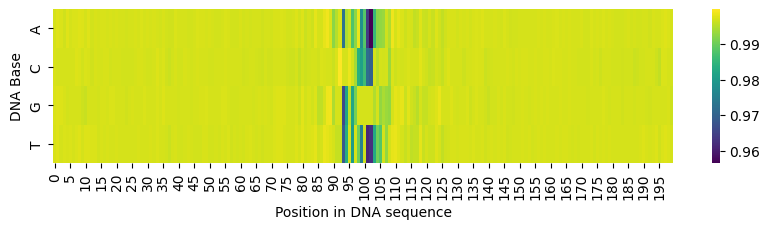

In [42]:
plt.figure(figsize=(10, 2))
sns.heatmap(preds.T, cmap="viridis", yticklabels=["A", "C", "G", "T"])
plt.xlabel("Position in DNA sequence")
plt.ylabel("DNA Base");

Reconsider the baseline (0.95)

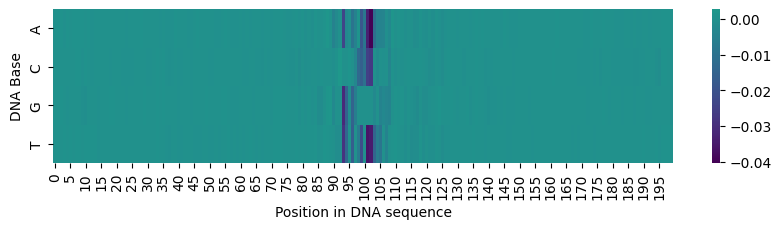

In [43]:
baseline_pred = nn.sigmoid(
  model.apply({"params": state.params}, original_sequence[None, :])
)
deltas = preds - baseline_pred

plt.figure(figsize=(10, 2))
sns.heatmap(deltas.T, center=0, cmap="viridis", yticklabels=["A", "C", "G", "T"])
plt.xlabel("Position in DNA sequence")
plt.ylabel("DNA Base");

In [19]:
from dlfb.dna.inspect import describe_change

display([describe_change])

def describe_change(
  idx, deltas: np.ndarray, sequence: np.ndarray, bases=["A", "C", "G", "T"]
) -> str:
  """Describe the effect of mutating one base to another."""
  seq_pos, base_idx = idx
  original_base = bases[np.argmax(sequence[seq_pos])]
  new_base = bases[base_idx]
  perc_delta = deltas[idx].item() * 100
  direction = "increase" if perc_delta >= 0 else "decrease"
  mutation = f"{original_base}→{new_base}"
  change = f"position {seq_pos} with {mutation} ({perc_delta:.2f}% {direction})"
  return change

In [45]:
for i in range(4):
  print(describe_change((100, i), deltas, original_sequence))

position 100 with G→A (-0.86% decrease)
position 100 with G→C (-1.07% decrease)
position 100 with G→G (0.00% increase)
position 100 with G→T (-0.05% decrease)


In [20]:
from dlfb.dna.inspect import plot_binding_site

importance = np.sum(np.abs(deltas), axis=1) # sum up across all mutations
plot_binding_site(
  panels={
    "tiles": {"label": "Deltas", "values": deltas},
    "line": {"label": "Importance", "values": importance},
  }
);

NameError: name 'deltas' is not defined

#### 3.4.1.2. Verifying Motif Presence


First we need to convert one hot encoding back to ACTG sequence

In [21]:
from dlfb.dna.utils import one_hot_to_dna

display([one_hot_to_dna])

def one_hot_to_dna(one_hot_encoded: np.ndarray) -> str:
  """Convert one-hot encoded array back to DNA sequence."""
  one_hot_to_base = {
    (1, 0, 0, 0): "A",
    (0, 1, 0, 0): "C",
    (0, 0, 1, 0): "G",
    (0, 0, 0, 1): "T",
    (1, 1, 1, 1): "N",  # N represents any unknown or ambiguous base.
  }

  dna_sequence = "".join(
    one_hot_to_base[tuple(base)] for base in one_hot_encoded
  )
  return dna_sequence

In [48]:
print(one_hot_to_dna(original_sequence)[0:25], "...")

ACCCCAGGGTAGGGCCTATTGTATG ...


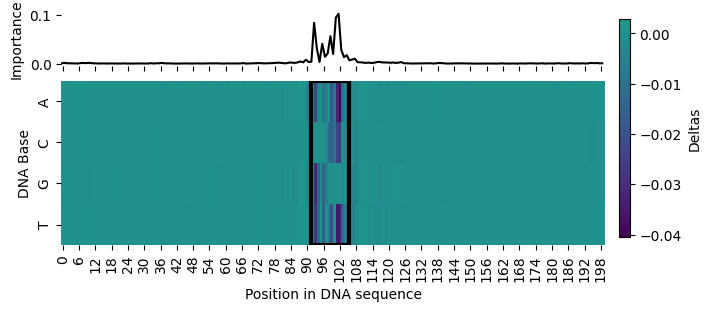

In [49]:
plot_binding_site(
  panels={
    "tiles": {"label": "Deltas", "values": deltas},
    "line": {"label": "Importance", "values": importance},
  },
  highlight=(92, 106),
);

The highlighted region is verified by FIMO tool.

#### 3.4.1.3. Implementing Input Gradients


Mathematically, this corresponds to computing the gradient of the model’s prediction with respect to its input sequence. If a small change in a particular base results in a large change in the output, that base must be important. The implementation is straightforward. We use jax.grad to take the derivative of the model’s predicted binding probability with respect to the one-hot input sequence.

In [22]:
from dlfb.dna.utils import compute_input_gradient

display([compute_input_gradient])

@jax.jit
def compute_input_gradient(state, sequence):
  """Compute input gradient for a one-hot DNA sequence."""
  if len(sequence.shape) != 2:
    raise ValueError("Input must be a single one-hot encoded DNA sequence.")

  sequence = jnp.asarray(sequence, dtype=jnp.float32)[None, :]

  def predict(sequence):
    # We take the mean to ensure we have a single scalar to take the grad of.
    return jnp.mean(state.apply_fn({"params": state.params}, sequence))

  gradient = jax.grad(lambda x: predict(x))(sequence)
  return jnp.squeeze(gradient)

In [51]:
input_gradient = compute_input_gradient(state, original_sequence)
input_gradient.shape

(200, 4)

However, input gradients differ from ISM in key ways: the values are not bounded to represent discrete mutations, and even the base currently present at each position can have a nonzero gradient. This is because the gradient describes how the model’s output would change with an infinitesimal increase in that base’s activation—not an actual mutation. This makes gradients a bit more abstract but also more flexible and computationally efficient.

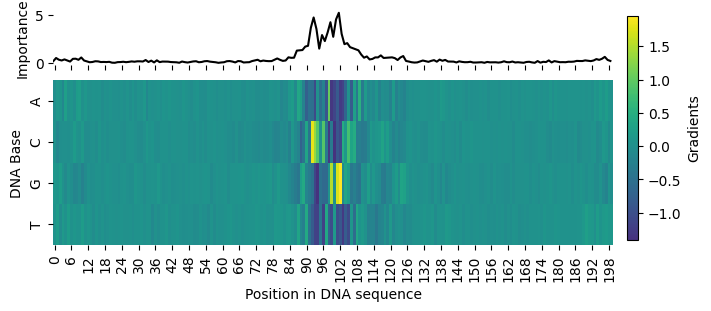

In [52]:
importance = np.sum(np.abs(input_gradient), axis=1) # take only absolute sum across bases
plot_binding_site(
  panels={
    "tiles": {"label": "Gradients", "values": input_gradient},
    "line": {"label": "Importance", "values": importance},
  },
);

Central DNA sequence with high importance:  TGGCCTCTGGGGGCGCTCTG


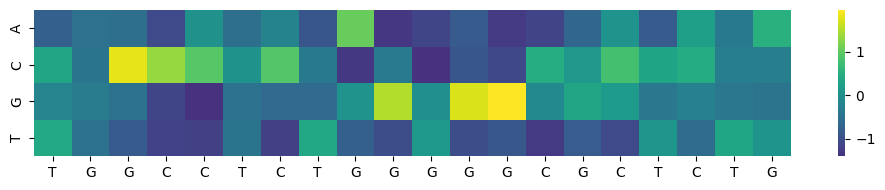

In [53]:
important_sequence = one_hot_to_dna(original_sequence)[90:110]
print("Central DNA sequence with high importance: ", important_sequence)

plt.figure(figsize=(10, 2))
sns.heatmap(
  input_gradient[90:110].T,
  cmap="viridis",
  center=0,
  xticklabels=important_sequence,
  yticklabels=["A", "C", "G", "T"],
)
plt.tight_layout();

Unlike in silico mutagenesis, input gradients do not simulate base changes. Instead, they show how the model’s output would change if you slightly nudged the input toward each of the four bases—even the one that’s already there. So a high gradient at a G→G position (i.e., where the base is already G), as in Figure 3-13, doesn’t mean “mutating G to G is important” (which would be meaningless). Instead, it means: The model is sensitive to the presence of that G. A tiny increase in the “G-ness” at that position would meaningfully affect the prediction. This G is contributing strongly to the model’s decision. In other words, if this G were somehow made even more G—despite already being fully G—the model’s output would shift. That’s not biologically plausible, but it’s a side effect of how gradients work mathematically.

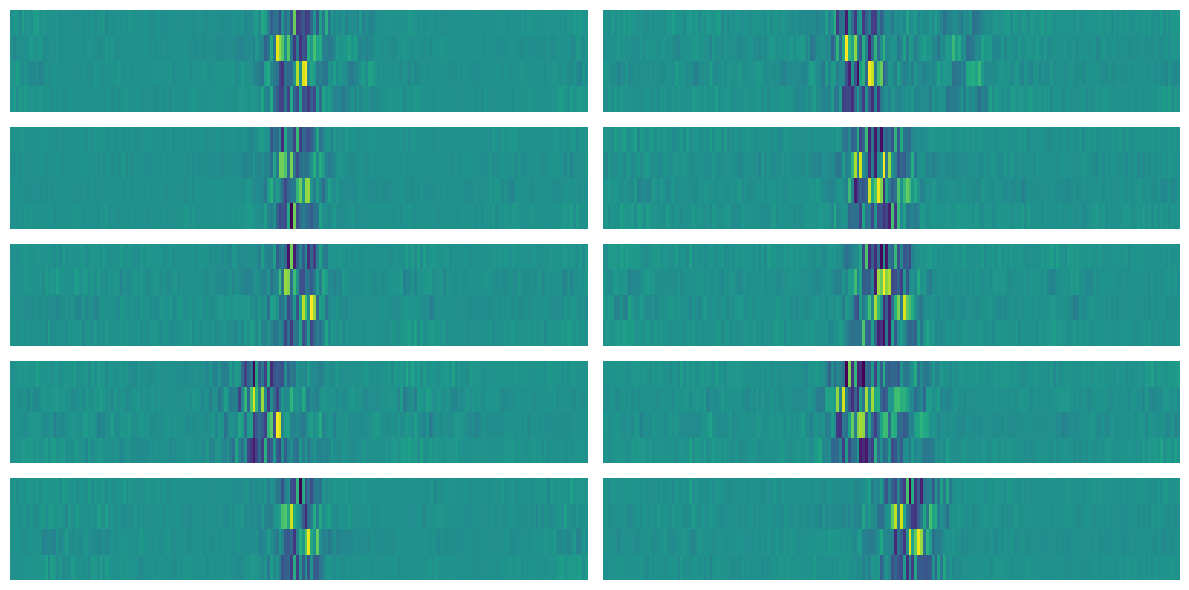

In [54]:
from dlfb.dna.inspect import plot_10_gradients

plot_10_gradients(state, valid_ds, target_label=1);

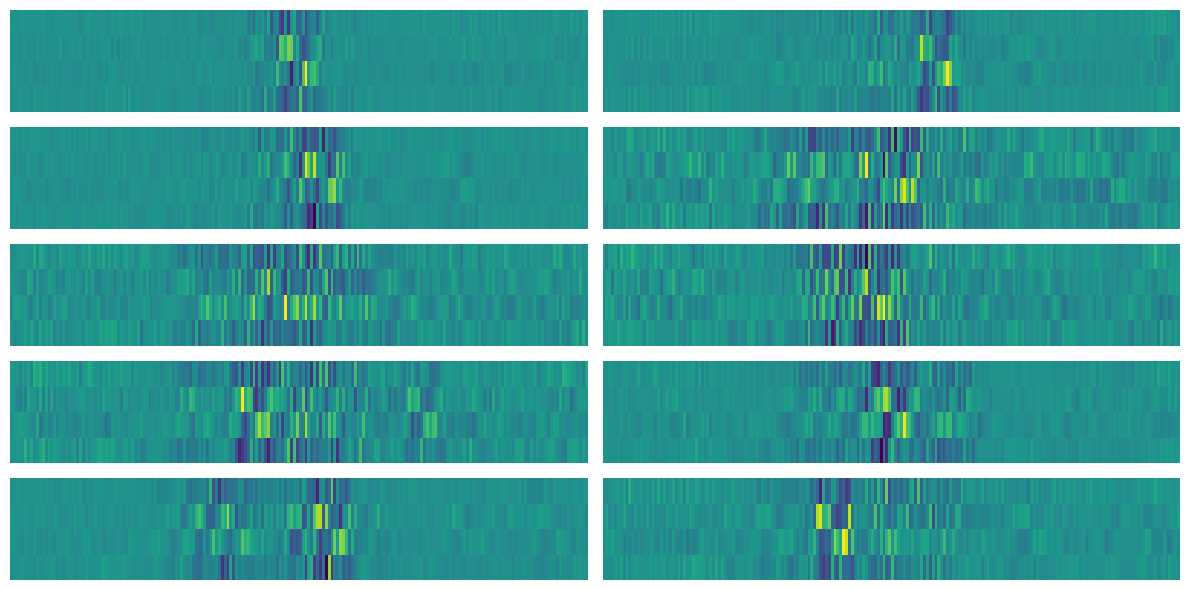

In [55]:
plot_10_gradients(state, valid_ds, target_label=0);

These findings serve as a good reminder that contribution scores like input gradients don’t just reflect the presence or absence of strong motifs. They also reveal where the model is looking for evidence and can surface subtle or confounding biological signals introduced by dataset design choices. In this case, the weak central patterns likely reflect a bias introduced by sampling from peak-centered open chromatin, even in negative (class 0) examples.

### 3.4.2. Modelling Multiple Transcription Factors
#### 3.4.2.1. Preparing a Multi-TF Dataset


In [23]:
transcription_factors = [
  "ARID3",
  "ATF2",
  "BACH1",
  "CTCF",
  "ELK1",
  "GABPA",
  "MAX",
  "REST",
  "SRF",
  "ZNF24",
]

#### 3.4.2.2. Defining a More Complex Model


**Important** To avoid conflicts between package dependency, somehow do not run the first CNN model

Dynamic learning rates usually start high (encouraging fast exploration) and decrease over time to help convergence.

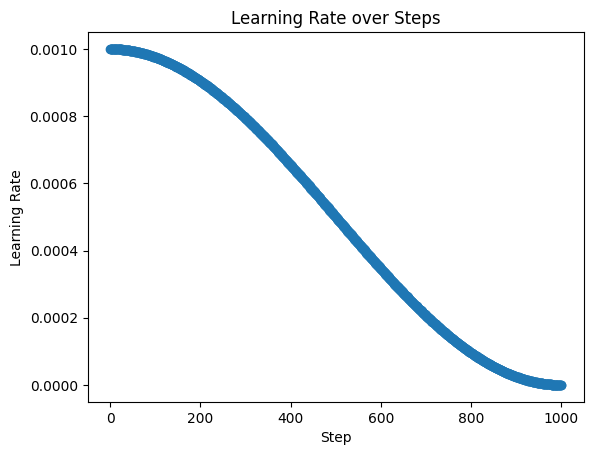

In [28]:
num_steps = 1000

scheduler = optax.cosine_decay_schedule(
  init_value=0.001,
  decay_steps=num_steps,  # How long to decay over.
)
learning_rates = [scheduler(i) for i in range(num_steps)]

plt.scatter(range(num_steps), learning_rates)
plt.title("Learning Rate over Steps")
plt.ylabel("Learning Rate")
plt.xlabel("Step");

In [ ]:
from dlfb.dna.model import ConvModelV2

display([ConvModelV2])
# in this version, a few updates were included
# - Batch normalization layers after convolutional layers to accelerate convergence (norm over whole batch on one feature)
# - Dropout layers after dense layers to avoid overfitting

class ConvModelV2(nn.Module):
  """CNN with batch norm and dropout for binary classification."""

  conv_filters: int = 64  # Number of filters for conv layers.
  kernel_size: tuple[int] = (10,)  # Kernel size for 1D conv layers.
  dense_units: int = 128  # Units in first dense fully connected layer.
  dropout_rate: float = 0.2  # Proportion of dense neurons to randomly drop out.

  @nn.compact
  def __call__(self, x, is_training: bool = True):
    # First convolutional layer.
    x = nn.Conv(
      features=self.conv_filters, kernel_size=self.kernel_size, padding="SAME"
    )(x)
    x = nn.BatchNorm(use_running_average=not is_training)(x)
    x = nn.gelu(x)
    x = nn.max_pool(x, window_shape=(2,), strides=(2,))

    # Second convolutional layer.
    x = nn.Conv(
      features=self.conv_filters, kernel_size=self.kernel_size, padding="SAME"
    )(x)
    #       as the first layer (see above). In a future release this will be
    #       updated.
    #       -> https://github.com/orgs/deep-learning-for-biology/discussions/10
    x = nn.gelu(x)
    x = nn.BatchNorm(use_running_average=not is_training)(x)
    x = nn.max_pool(x, window_shape=(2,), strides=(2,))

    # Flatten the values before passing them to the dense layers.
    x = x.reshape((x.shape[0], -1))

    # First dense layer.
    x = nn.Dense(self.dense_units)(x)
    x = nn.gelu(x)
    x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not is_training)

    # Second dense layer.
    x = nn.Dense(self.dense_units // 2)(x)
    x = nn.gelu(x)
    x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not is_training)

    # Output layer (single unit for binary classification).
    return nn.Dense(1)(x)

  def create_train_state(self, rng: jax.Array, dummy_input, tx):
    """Initializes model parameters and returns a train state for training."""
    rng, rng_init, rng_dropout = jax.random.split(rng, 3)
    variables = self.init(rng_init, dummy_input)
    state = TrainStateWithBatchNorm.create(
      apply_fn=self.apply,
      tx=tx,
      params=variables["params"],
      batch_stats=variables["batch_stats"],
      key=rng_dropout,
    )
    return state

In [ ]:
rng = jax.random.PRNGKey(42)
rng, rng_init, rng_train = jax.random.split(rng, 3) # set up random keys for params initialization and training
state = ConvModelV2().create_train_state(
  rng=rng_init, dummy_input=batch["sequences"], tx=optax.adam(scheduler)
)

In [ ]:
from dlfb.dna.train import train_step

display([train_step])
# loss is computed by averaging sigmoid_binary_cross_entropy over the batch

@jax.jit
def train_step(state, batch, rng_dropout: jax.Array):
  """Run a training step and update parameters."""

  def calculate_loss(params, batch):
    """Make predictions on batch and compute binary cross-entropy loss."""
    logits, updates = state.apply_fn(
      {"params": params, "batch_stats": state.batch_stats},
      x=batch["sequences"],
      is_training=True,
      rngs={"dropout": rng_dropout},
      mutable=["batch_stats"],
    )

    loss = optax.sigmoid_binary_cross_entropy(logits, batch["labels"]).mean()

    return loss, updates

  grad_fn = jax.value_and_grad(calculate_loss, has_aux=True)
  (loss, updates), grads = grad_fn(state.params, batch)
  state = state.apply_gradients(grads=grads)
  state = state.replace(batch_stats=updates["batch_stats"])

  metrics = {"loss": loss}

  return state, metrics

In [ ]:
# Overfit on one batch.
for i in range(5):
  rng, rng_dropout = jax.random.split(rng, 2) # set up random keys for dropout
  state, metrics = train_step(state, batch, rng_dropout)
  print(f"Step {i} loss: {metrics['loss']}")

Step 0 loss: 0.727774977684021
Step 1 loss: 0.2477683573961258
Step 2 loss: 0.10339795053005219
Step 3 loss: 0.023873351514339447
Step 4 loss: 0.014526530168950558


In [37]:
from dlfb.dna.train import compute_metrics, eval_step
# since scikit-learn is not compatible with JIT, these functions are not jitted (no decorator)
display([eval_step, compute_metrics])

def eval_step(state, batch):
  """Evaluate model on a single batch."""
  logits = state.apply_fn(
    {"params": state.params, "batch_stats": state.batch_stats},
    x=batch["sequences"],
    is_training=False,
    mutable=False,
  )
  loss = optax.sigmoid_binary_cross_entropy(logits, batch["labels"]).mean()
  metrics = {
    "loss": loss.item(),
    **compute_metrics(batch["labels"], logits),
  }
  return metrics


def compute_metrics(y_true: np.ndarray, logits: np.ndarray):
  """Compute accuracy and auROC for model predictions."""
  metrics = {
    "accuracy": accuracy_score(y_true, nn.sigmoid(logits) >= 0.5),
    "auc": roc_auc_score(y_true, logits).item(),
  }
  return metrics

In [38]:
# Evaluate the batch.
metrics = eval_step(state, batch)
print(metrics)

{'loss': 0.48696064949035645, 'accuracy': 1.0, 'auc': 1.0}


In [39]:
from dlfb.dna.train import train

display([train])

@restorable
def train(
  state: TrainStateWithBatchNorm,
  rng: jax.Array,
  dataset_splits: dict[str, tf.data.Dataset],
  num_steps: int,
  eval_every: int = 100,
) -> tuple[TrainStateWithBatchNorm, Any]:
  """Train a model and log metrics over steps."""
  metrics = MetricsLogger()
  train_batches = dataset_splits["train"].as_numpy_iterator()

  steps = tqdm(range(num_steps))  # Steps with progress bar.
  for step in steps:
    steps.set_description(f"Step {step + 1}")

    rng, rng_dropout = jax.random.split(rng, 2)
    train_batch = next(train_batches)
    state, batch_metrics = train_step(state, train_batch, rng_dropout)
    metrics.log_step(split="train", **batch_metrics)

    if step % eval_every == 0:
      for eval_batch in dataset_splits["valid"].as_numpy_iterator():
        batch_metrics = eval_step(state, eval_batch)
        metrics.log_step(split="valid", **batch_metrics)
      metrics.flush(step=step)

    steps.set_postfix_str(metrics.latest(["loss"]))

  return state, metrics.export()

In [40]:
from dlfb.dna.dataset import load_dataset_splits

display([load_dataset_splits]) # load data by TF names and splits

def load_dataset_splits(
  path, transcription_factor, batch_size: int | None = None
):
  """Load TF dataset splits (train, valid, test) as TensorFlow datasets."""
  dataset_splits = {}
  for split in ["train", "valid", "test"]:
    dataset = load_dataset(
      sequence_db=f"{path}/{transcription_factor}_{split}_sequences.csv"
    )
    ds = convert_to_tfds(dataset, batch_size, is_training=(split == "train"))
    dataset_splits.update({split: ds})
  return dataset_splits

Train the model TF by TF

In [41]:
prefix = assets("dna/datasets")
tf_metrics = {}

# Train one model per transcription factor.
for transcription_factor in transcription_factors:
  # Load data for this TF.
  dataset_splits = load_dataset_splits(
    assets("dna/datasets"), transcription_factor, batch_size
  )
  rng = jax.random.PRNGKey(42)
  rng, rng_init, rng_train = jax.random.split(rng, 3)
  dummy_batch = next(dataset_splits["train"].as_numpy_iterator())["sequences"]

  # Create train state.
  state = ConvModelV2().create_train_state(
    rng=rng_init,
    dummy_input=dummy_batch,
    tx=optax.adam(scheduler),
  )

  # Train the model.
  _, metrics = train(
    state=state,
    rng=rng_train,
    dataset_splits=dataset_splits,
    num_steps=num_steps,
    eval_every=100,
    store_path=assets(f"dna/models/{transcription_factor}"),
  )

  # Store metrics.
  tf_metrics.update({transcription_factor: metrics})

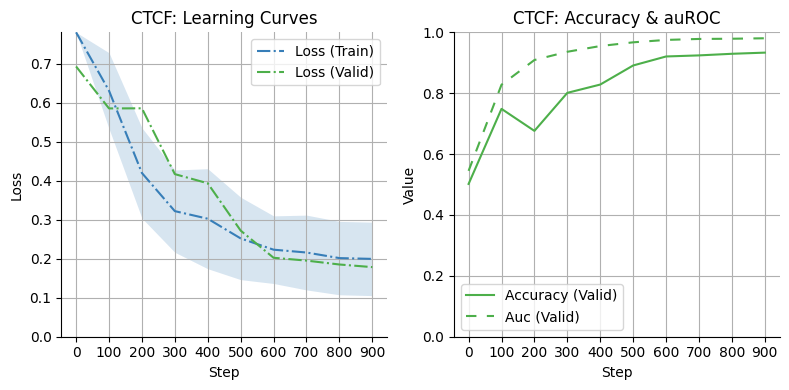

In [42]:
from dlfb.dna.inspect import plot_learning

tf = "CTCF"
plot_learning(tf_metrics[tf], tf);

In [43]:
from dlfb.utils.metric_plots import to_df

# Extract metrics logged per transcription factor.
tf_df = []
for tf, metrics in tf_metrics.items():
  tf_df.append(to_df(metrics).assign(TF=tf))
tf_df = pd.concat(tf_df)

# Determine order of best performance.
auc_df = tf_df[(tf_df["metric"] == "auc") & (tf_df["split"] == "valid")]
max_auc_by_tf = auc_df.groupby("TF")["mean"].max()
tf_order = max_auc_by_tf.sort_values(ascending=False).index.tolist()
tf_df["TF"] = pd.Categorical(tf_df["TF"], categories=tf_order, ordered=True)

In [44]:
sns.set_context("notebook", font_scale=3, rc={"lines.linewidth": 2.5})
sns.set_style("ticks", {"axes.grid": True})
g = sns.relplot(
  data=tf_df,
  x="round",
  y="mean",
  hue="split",
  style="metric",
  kind="line",
  col="TF",
  col_order=tf_order,
  col_wrap=4,
  alpha=0.8,
  palette=DEFAULT_SPLIT_COLORS,
  dashes=True,
)
g.set_axis_labels("Step", "Value")
g.set(ylim=(0, 1));

NameError: name 'DEFAULT_SPLIT_COLORS' is not defined

In [17]:
print(max_auc_by_tf.sort_values(ascending=False))

TF
ATF2     0.985182
CTCF     0.980479
SRF      0.849944
           ...   
ARID3    0.769149
BACH1    0.767122
ZNF24    0.761506
Name: mean, Length: 10, dtype: float64


## 3.5. Advanced Techniques


Before we introduce more complex model components, let’s first improve the clarity and modularity of our model architecture by refactoring it into reusable building blocks. This makes our code easier to read, extend, and maintain. We will modularize our convolutional and MLP layers by creating two helper modules, ConvBlock and MLPBlock.

In [45]:
from dlfb.dna.model import ConvBlock, MLPBlock

display([ConvBlock, MLPBlock])

class ConvBlock(nn.Module):
  """Convolutional block with batch norm, GELU and max pooling."""

  conv_filters: int
  kernel_size: tuple[int]
  pool_size: int

  @nn.compact
  def __call__(self, x, is_training: bool = True):
    x = nn.Conv(
      features=self.conv_filters, kernel_size=self.kernel_size, padding="SAME"
    )(x)
    x = nn.BatchNorm(use_running_average=not is_training)(x)
    x = nn.gelu(x)
    x = nn.max_pool(
      x, window_shape=(self.pool_size,), strides=(self.pool_size,)
    )
    return x


class MLPBlock(nn.Module):
  """Dense + GELU + dropout block."""

  dense_units: int
  dropout_rate: float = 0.0

  @nn.compact
  def __call__(self, x, is_training: bool = True):
    x = nn.Dense(self.dense_units)(x)
    x = nn.gelu(x)
    x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not is_training)
    return x

Define a transformer model on top of the code blocks.

In [47]:
from dlfb.dna.model import ConvTransformerModel

display([ConvTransformerModel], hide=[ConvTransformerModel.create_train_state])

# optional transformer blocks between convolutional and MLP layers

class ConvTransformerModel(nn.Module):
  """Model combining CNN, transformer, and MLP blocks."""

  num_conv_blocks: int = 2
  conv_filters: int = 64
  kernel_size: tuple[int] = (10,)
  num_mlp_blocks: int = 2
  dense_units: int = 128
  dropout_rate: float = 0.2  # Global.
  num_transformer_blocks: int = 0
  num_transformer_heads: int = 8
  transformer_dense_units: int = 64

  @nn.compact
  def __call__(self, x, is_training: bool = True):
    for _ in range(self.num_conv_blocks):
      x = ConvBlock(
        conv_filters=self.conv_filters,
        kernel_size=self.kernel_size,
        pool_size=2,
      )(x, is_training)

    for i in range(self.num_transformer_blocks):
      x = TransformerBlock(
        num_heads=self.num_transformer_heads,
        dense_units=self.transformer_dense_units,
        dropout_rate=self.dropout_rate,
      )(x, is_training)

    x = x.reshape((x.shape[0], -1))

    for i in range(self.num_mlp_blocks):
      x = MLPBlock(
        dense_units=self.dense_units // (i + 1), dropout_rate=self.dropout_rate
      )(x, is_training)

    return nn.Dense(1)(x)

### 3.5.1. Adding Self-attention and Transformer Blocks


Here, a transformer block include:
- Layer normalization
- Multi-head attention
- Skip connection (x+residual) and layer normalization
- Dense layer 1 with dropout and gelu
- Dense layer 2 without dropout and gelu
- Skip connection

In [48]:
from dlfb.dna.model import TransformerBlock

display([TransformerBlock])

# residual connection allows gradients to flow more easily
# layer normalization (norm over all features in a layer)
# no positional encoding as DNA sequences are relatively short

class TransformerBlock(nn.Module):
  """Transformer block with self-attention and MLP."""

  num_heads: int = 8
  dense_units: int = 64
  dropout_rate: float = 0.2

  @nn.compact
  def __call__(self, x, is_training: bool = True):
    # Self-attention with layer norm.
    residual = x
    x = nn.LayerNorm()(x)
    x = nn.SelfAttention(num_heads=self.num_heads)(x)
    x += residual

    # Feedforward block.
    residual = x
    x = nn.LayerNorm()(x)
    x = nn.Dense(self.dense_units)(x)
    x = nn.gelu(x)
    x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not is_training)
    x = nn.Dense(self.dense_units)(x)  # No GELU after this Dense.
    x += residual
    return x

### 3.5.2. Defining Various Model Architectures


In [49]:
models = {
  # Our standard 2-layer CNN with dropout and MLP.
  "baseline": ConvTransformerModel(),
  # Ablations: Remove or reduce certain components.
  # Only a single convolutional block.
  "single_conv_only": ConvTransformerModel(
    num_conv_blocks=1, num_transformer_blocks=0, num_mlp_blocks=0
  ),
  # Reduced capacity by lowering conv filters.
  "fewer_conv_channels": ConvTransformerModel(conv_filters=8),
  # Drop the MLP layers to test if they help.
  "remove_MLP": ConvTransformerModel(num_mlp_blocks=0),
  # Potential improvements: Add more expressive capacity.
  # Add a transformer block after convolutions.
  "add_one_transformer_block": ConvTransformerModel(num_transformer_blocks=1),
  # Stack two transformer blocks.
  "add_two_transformer_block": ConvTransformerModel(num_transformer_blocks=2),
}

To test these variants, we’ll focus on the most difficult TF from our earlier results: ZNF24, which achieved a peak validation auROC of 0.76 in our initial model. This makes it a great candidate to explore whether architectural improvements can lead to better predictive performance.

### 3.5.3. Sweeping Over the Different Models


Train and test architecture on ZNF24

In [51]:
# Train and evaluate multiple model architectures on the ZNF24 dataset.
transcription_factor = "ZNF24"
learning_rate = 0.001
dataset_splits = load_dataset_splits(
  assets("dna/datasets"), transcription_factor, batch_size
)

# Prepare a dummy input for model initialization.
dummy_input = next(dataset_splits["train"].as_numpy_iterator())["sequences"]

# Initialize PRNGs.
rng = jax.random.PRNGKey(42)
rng, rng_init, rng_train = jax.random.split(rng, 3)

# Dictionary to store metrics for each model variant.
model_metrics = {}

# Train each model variant and store its metrics.
for name, model in models.items():
  # initialize model parameters with dummy input
  state = model.create_train_state(
    rng=rng_init,
    dummy_input=dummy_input,
    tx=optax.adamw(
      optax.cosine_decay_schedule(
        init_value=learning_rate,
        decay_steps=num_steps,
      )
    ),
  )
  _, metrics = train(
    state=state,
    rng=rng_train,
    dataset_splits=dataset_splits,
    num_steps=num_steps,
    eval_every=100,
    store_path=assets(f"dna/models/{name}"),
  )
  model_metrics.update({name: metrics})

After training each model, we extract logged metrics over training time and visualize the results:

In [52]:
# Extract metrics logged per transcription factor.
model_df = []
for model, metrics in model_metrics.items():
  model_df.append(to_df(metrics).assign(model=model))
model_df = pd.concat(model_df)

# Determine order of best performance.
auc_df = model_df[
  (model_df["metric"] == "auc") & (model_df["split"] == "valid")
]
max_auc_by_model = auc_df.groupby("model")["mean"].max()
model_order = max_auc_by_model.sort_values(ascending=False).index.tolist()
model_df["model"] = pd.Categorical(
  model_df["model"], categories=model_order, ordered=True
)

Plot learning curves and metrics.

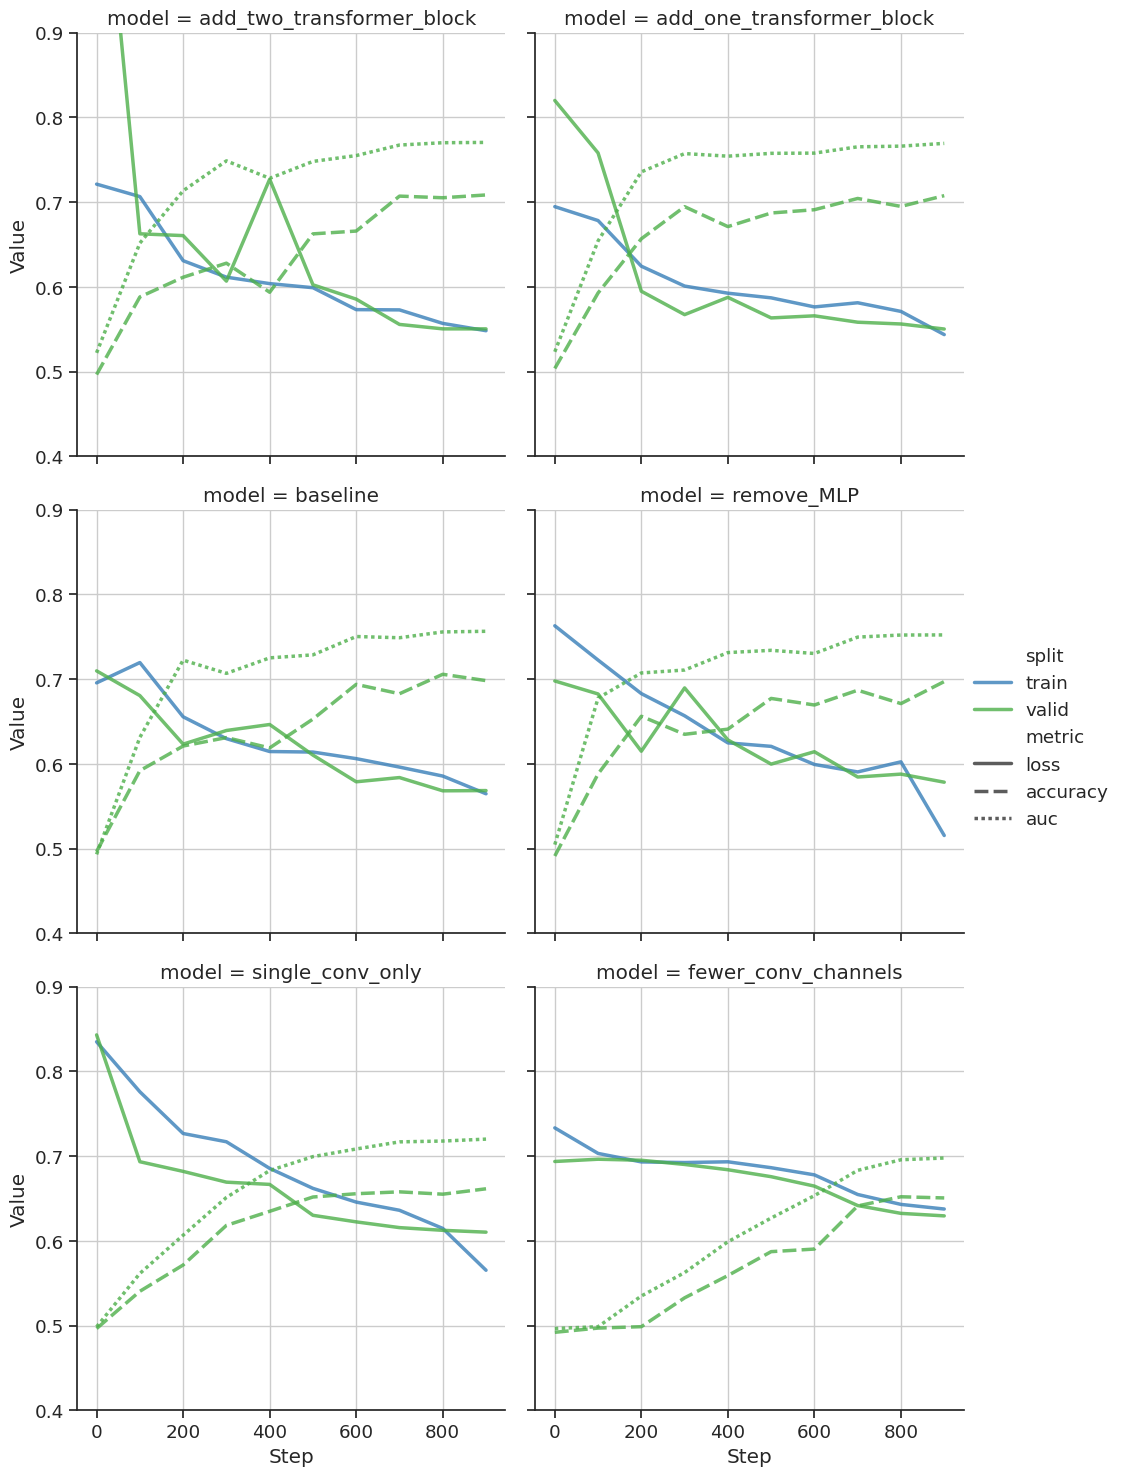

In [55]:
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
sns.set_style("ticks", {"axes.grid": True})
g = sns.relplot(
  data=model_df,
  x="round",
  y="mean",
  hue="split",
  style="metric",
  kind="line",
  col="model",
  col_order=model_order,
  col_wrap=2,
  alpha=0.8,
  palette=DEFAULT_SPLIT_COLORS,
  dashes=True,
)
g.set_axis_labels("Step", "Value")
g.set(ylim=(0.4, 0.9));

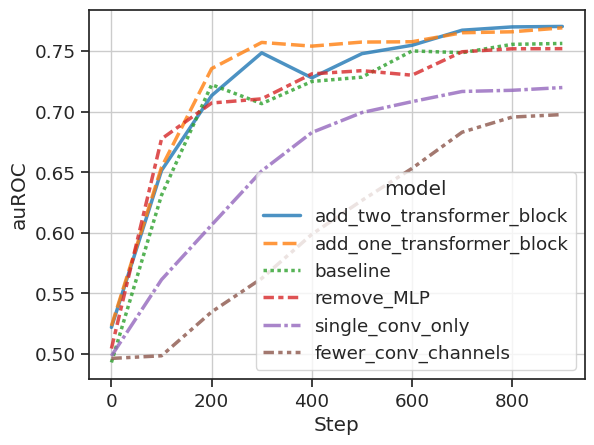

In [56]:
g = sns.lineplot(
  data=model_df[(model_df["metric"] == "auc")],
  x="round",
  y="mean",
  hue="model",
  style="model",
  alpha=0.8,
)
g.set_xlabel("Step")
g.set_ylabel("auROC");

In [57]:
print(max_auc_by_model.sort_values(ascending=False))

model
add_two_transformer_block    0.770343
add_one_transformer_block    0.769196
baseline                     0.756317
remove_MLP                   0.752024
single_conv_only             0.719931
fewer_conv_channels          0.697637
Name: mean, dtype: float64


- Convolutions are critical: The single_conv_only model underperforms relative to the baseline, and reducing the number of convolutional filters degrades performance further. This suggests that having multiple convolutional layers with sufficient capacity is important for learning meaningful sequence features. It may be worth exploring deeper convolutional stacks or wider kernels.
- Transformer can help: Adding one or two self-attention blocks gives a modest but consistent improvement in auROC, despite the input sequences being only 200 bp long. This supports the idea that even short DNA windows can benefit from modeling long-range dependencies.
- MLPs may be unnecessary: Surprisingly, removing the MLP blocks doesn’t drastically hurt performance. This suggests that most of the representational power is coming from earlier convolutional layers, and the additional MLP layers may be redundant.

### 3.5.4. Evaluating on the Test Split


In [58]:
from dlfb.utils.restore import restore

# Identify best-performing model variant based on validation auROC.
top_model = model_order[0]

# Restore the trained model state from disk.
state, _ = restore(
  assets(f"dna/models/{top_model}"),
  models[top_model].create_train_state(
    rng=rng_init,
    dummy_input=next(dataset_splits["train"].as_numpy_iterator())["sequences"],
    tx=optax.adamw(
      optax.cosine_decay_schedule(
        init_value=learning_rate,
        decay_steps=num_steps,
      )
    ),
  ),
)

# Evaluate on the held-out test set.
test_batch = next(dataset_splits["test"].as_numpy_iterator())
metrics = eval_step(state, test_batch)
print(metrics)

{'loss': 0.5123618841171265, 'accuracy': 0.75, 'auc': 0.8196078431372549}


### 3.5.5. Extensions and Improvements


## 3.6. Summary
